In [1]:
!git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

Cloning into 'LightGBM'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 21280 (delta 2), reused 0 (delta 0), pack-reused 21270
Receiving objects: 100% (21280/21280), 16.75 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (15585/15585), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728       

In [2]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
import random
import matplotlib.pyplot as plt

Mounted at /content/drive


In [164]:
from sklearn.preprocessing import StandardScaler, PowerTransformer,QuantileTransformer ,LabelEncoder, OneHotEncoder, MinMaxScaler
import seaborn as sns
! pip install prince
import prince

In [70]:
path = '/content/drive/Shareddrives/dacon/Playground/'
train = pd.read_csv(path + 'train.csv', index_col=['id'])
test = pd.read_csv(path + 'test.csv', index_col=['id'])
submission = pd.read_csv(path + 'sample_submission.csv', index_col=['id'])

In [178]:
train_data = train.iloc[:,:-1]
train_target = train.iloc[:, -1]
test_data = test.copy()

In [103]:
train

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
2,B,A,A,A,B,B,A,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
3,A,A,A,C,B,D,A,B,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
4,A,A,A,C,B,D,A,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
6,A,B,A,A,B,B,A,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,A,B,A,C,B,B,A,E,E,L,0.260716,0.712438,0.161661,0.442794,0.768447,0.269578,0.258655,0.363598,0.300619,0.340516,0.235711,0.383477,0.215227,0.793630,8.343538
499996,A,B,A,C,B,B,A,E,E,L,0.173302,0.121591,0.592514,0.193711,0.775951,0.197211,0.257024,0.574304,0.227035,0.322583,0.286094,0.324874,0.306933,0.230902,7.851861
499997,A,B,A,C,B,B,A,E,C,M,0.342856,0.617869,0.462991,0.418098,0.297406,0.449482,0.386172,0.476217,0.135947,0.502730,0.235788,0.316671,0.250286,0.349041,7.600558


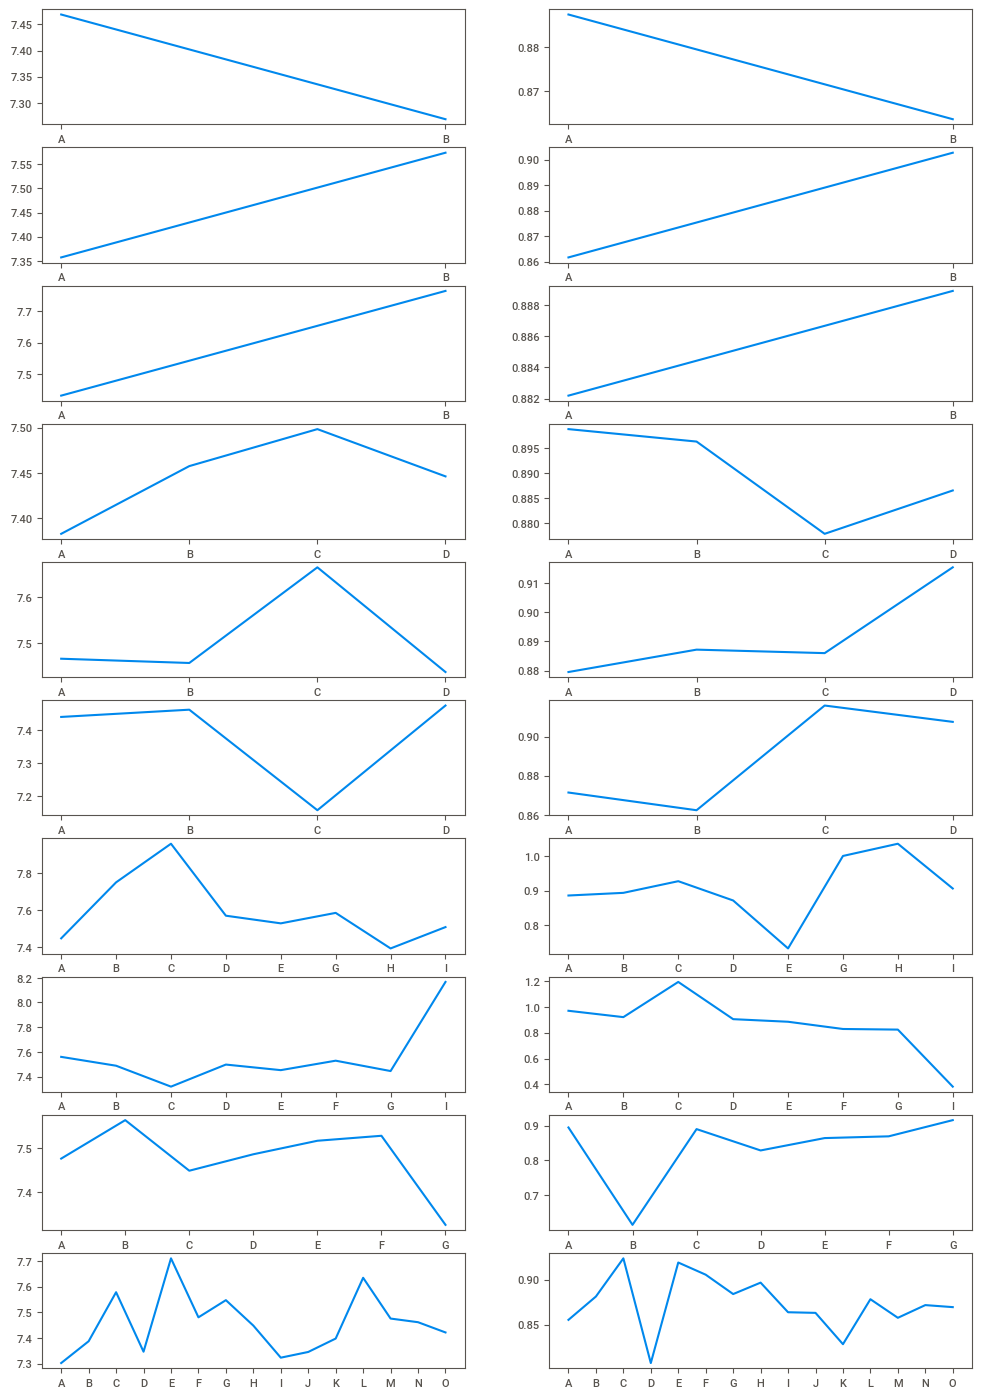

In [126]:
p = 1
plt.figure(figsize=(12, 18))
for i, cat in enumerate(cats):
  vals = train[cat].unique()
  vals.sort()
  mean_list = []
  std_list = []
  for j, val in enumerate(vals):
    a = train['target'][train[cat] == val].mean()
    b = train['target'][train[cat] == val].std()
    mean_list.append(a)
    std_list.append(b)
  plt.subplot(len(cats), 2, p)
  plt.plot(vals, mean_list)
  p += 1
  plt.subplot(len(cats), 2, p)
  p += 1
  plt.plot(vals, std_list)

plt.show()

In [130]:
train['cont0'].min()

-0.0935053605494934

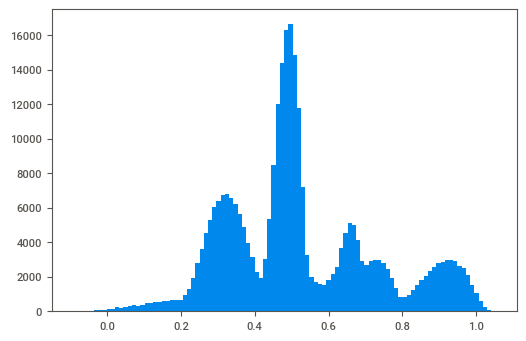

In [151]:
plt.hist(train['cont0'], bins = 100)
plt.show()

In [166]:
# scaler = QuantileTransformer(output_distribution='normal', n_quantiles=100)
scaler = MinMaxScaler()

In [179]:
train_data2 = train_data.copy()
test_data2 = test_data.copy()

train_data2.loc[:, 'cont0' : 'cont13'] = scaler.fit_transform(train_data.loc[:, 'cont0' : 'cont13'])
test_data2.loc[:, 'cont0' : 'cont13'] = scaler.transform(test_data.loc[:, 'cont0' : 'cont13'])

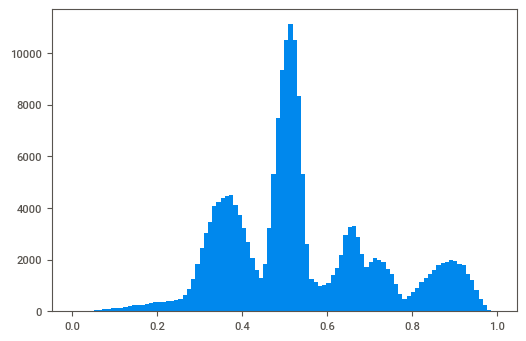

In [168]:
plt.hist(test_data2['cont0'], bins = 100)
plt.show()

In [176]:
famd = prince.FAMD(n_components=4, random_state=42)

In [180]:
famd = famd.fit(train_data2)

In [182]:
famd.row_coordinates(train_data2)

,0,1,2,3
id,,,,
1,1.756768,-0.204623,0.294447,0.166309
2,0.199388,-0.663602,-0.726836,-0.364835
3,1.872026,0.342352,-0.273625,-0.352903
4,1.644344,0.197291,-0.814944,-0.057432
6,-0.252812,-1.044743,0.775152,0.367448
...,...,...,...,...
499993,-1.604702,1.248510,0.296485,0.179591
499996,-1.824618,1.217478,0.224601,0.242492
499997,-1.206584,0.209648,0.198741,0.590951


In [183]:
famd.row_coordinates(test_data2)

ValueError: ignored

In [169]:
cats = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
# drops = ['cat0', 'cat2', 'cat4', 'cat6', 'cat7']

lefts = list(set(train_data.columns) - set(drops))
lefts.sort()

for i, cat in enumerate(cats):
  train_data[cat] = train_data[cat].astype('category')
  test_data[cat] = test_data[cat].astype('category')

X_train, X_valid, Y_train,  Y_valid = train_test_split(train_data2, train_target, test_size=0.20, random_state=42)

In [170]:
params = {}
# params['objective'] = 'quantile'
# params['min_child_samples'] = 10
# params['min_child_weight'] = 100
# params['min_split_gain'] = 0
params['n_estimators'] = 10000
# params['feature_fraction'] = 0.7
params['learning_rate'] = 0.01
# params['subsample'] = 0.7
# params['max_drop'] = 50
params['max_bin'] = 32
# params['num_leaves'] = 60
params['device'] = 'gpu'
# params['max_depth'] = 30
# params['boosting_type'] = "gbdt"

In [171]:
model = LGBMRegressor(**params)

In [172]:
model.fit(X_train, Y_train, eval_metric = ['RMSE'], eval_set=[(X_valid, Y_valid)], early_stopping_rounds=2000, verbose=1000)

Training until validation scores don't improve for 2000 rounds
[1000]	valid_0's rmse: 0.846945	valid_0's l2: 0.717316
[2000]	valid_0's rmse: 0.845878	valid_0's l2: 0.715509
[3000]	valid_0's rmse: 0.845857	valid_0's l2: 0.715475
[4000]	valid_0's rmse: 0.845837	valid_0's l2: 0.715441
[5000]	valid_0's rmse: 0.846012	valid_0's l2: 0.715737
Early stopping, best iteration is:
[3541]	valid_0's rmse: 0.845782	valid_0's l2: 0.715347


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              device='gpu', importance_type='split', learning_rate=0.01,
              max_bin=32, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
              n_jobs=-1, num_leaves=31, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [173]:
pred = model.predict(test_data2)

In [98]:
pred

array([7.6690357 , 7.92382428, 7.63750625, ..., 7.54013686, 7.51308485,
       7.36867874])

In [174]:
submission['target'] = pred

In [ ]:
fi = pd.DataFrame(model.feature_importances_, index = model.feature_name_)

In [175]:
submission.to_csv('submission.csv')
!cp submission.csv "drive/My Drive/"

In [ ]:
# !pip install sweetviz
# import sweetviz as sv

In [62]:
# df = sv.compare(train_data, test_data)
# df.show_html("drive/My Drive/cp.html")


Report drive/My Drive/cp.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
